In [0]:
import pandas as pd
import numpy as np
import random
import nltk
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import math
import string
import gensim
import re

import matplotlib.pyplot as plt

import itertools as it
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
#import warnings
from nltk.stem import WordNetLemmatizer
import operator
from gensim.models import Word2Vec

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
tokenizer = RegexpTokenizer(r'\w+') # Tokenizer for tweets
wordnet_lemmatizer = WordNetLemmatizer() # For lemmatization of words

In [0]:
# Returns list of stop words

def get_stopwords():
    
    stop_words = set(stopwords.words('english'))
    stop_words.update([x for x in ENGLISH_STOP_WORDS])

    return list(stop_words)

In [0]:
stop_words_list = get_stopwords()

In [0]:
def get_corpus_tokens(tweet_list):
    
    all_tokens = [] # list of list

    # loop through document list
    for tweet in tweet_list:
        tokens = tokenizer.tokenize(tweet)
        all_tokens.append(tokens)
    #print(tokens, all_tokens)
    return all_tokens

In [0]:
def clean_tweet(tweet, stop_words_list):
    
    tokenizer = RegexpTokenizer(r'\w+')
    wordnet_lemmatizer = WordNetLemmatizer()
    raw = tweet.lower().strip()
    raw = raw.replace("'", "")
    raw = re.sub(r"\s*http://www\.[a-z]+\.[a-z]+\s*", " ", raw) #weblink
    re.sub(r"\s*http://[a-z|\.|/]+\.htm\s*", " ", raw) # weblink
    re.sub(r"\s*[a-z]+@[a-z]+\.[a-z]+\s*", " ", raw) # email
    raw = raw.replace("\n", " ")
    raw = re.sub('[^a-z]+', ' ', raw)
    tokens = tokenizer.tokenize(raw)
    lemma_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    # stopped_tokens =  [token for token in tokens if not token in stop_words_list]
    clean_tokens = [token for token in lemma_tokens if len(token) > 1]
    cleaned_tweet = " ".join(clean_tokens)
        
    return cleaned_tweet

In [0]:
def get_trans_vector(trans, model):
    count = 0
    vec = []
    
    for token in re.split('\s+', trans):
        if token in model:
            if count == 0:
                vec = model[token]
            else:
                vec = operator.add(vec, model[token])
            count = count + 1
         
    vec = [float(x / float(count)) for x in vec]
    return vec

In [0]:
def get_word_2_vec_fv(data, model):
    FV = []
    label_list = []

    for row in data.index:
        twt = data['cleaned_tweet'][row]
        vec = get_trans_vector(twt, model)
        if len(vec) == 100:
          FV.append(vec)
          label_list.append(data['label'][row])
    return FV, label_list

In [0]:
def display_accuracy(pred, label_vector):
    print(accuracy_score(label_vector, pred))
    print(confusion_matrix(label_vector, pred))
    print(classification_report(label_vector, pred))

In [0]:
def get_binary_classifcations(pred, threshold=0.5):
    bin_pred = []
    for p in pred:
        if(p > threshold):
            bin_pred.append(1.0)
        else:
            bin_pred.append(0.0)
    return bin_pred

In [0]:
def get_lstm_model(xtrain, ytrain):
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, 100)))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    dataX = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
    
    #class_weights = class_weight.compute_class_weight('balanced', np.unique(ytrain), ytrain)
    print(model.summary())
    #print(class_weights)
    #class_weight_dic = {0:class_weight[0],1:class_weight[1]}
    #print(type(class_weight))
    #model.fit(dataX, ytrain, epochs=250, batch_size=5, class_weight={0:0.54229935,1:6.41025641}, verbose=0)
    model.fit(dataX, ytrain, epochs=248, batch_size=5, verbose=0)
    return model

In [0]:
def train_w2v_model(train, test):
    cleaned_tweet_list = list(train['cleaned_tweet'].values) + list(test['cleaned_tweet'].values)
    all_tokens = get_corpus_tokens(cleaned_tweet_list)
    w2v_model = Word2Vec(all_tokens, min_count=1,sg=1,window=8)
    return w2v_model

In [0]:
def get_train_test(FV, label_list, split_size):
    seed = 7
    X_train, X_validation, Y_train, Y_validation = train_test_split(FV, label_list, test_size=split_size, random_state=seed)
    print('hi',np.shape(X_train))
    xtrain = np.asarray(X_train, dtype = np.float64)
    print('tt2')
    xtest = np.asarray(X_validation, dtype = np.float64)
    print('tt3')
    ytrain = np.asarray(Y_train, dtype = np.float64)
    print('tt4')
    ytest = np.asarray(Y_validation, dtype = np.float64)
    print('tt5')
    return xtrain, xtest, ytrain, ytest

In [0]:
# ROC curves

def plot_roc(actual, pred): 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [0]:
"""def training(file_name):
    df = pd.read_csv(filename)
    df['ngv_qlty_1'] = df['ngv_qlty_1'].astype('int32') 

    #Cleaning the tweets
    df['cleaned_tweet'] = df.apply(lambda row : clean_tweet(row['text'], stop_words_list), axis=1) 

    w2v_model = train_w2v_model(df)

    df['feature'] = df.apply(lambda row : get_trans_vector(row['cleaned_tweet'], w2v_model), axis=1)
"""





"def training(file_name):\n    df = pd.read_csv(filename)\n    df['ngv_qlty_1'] = df['ngv_qlty_1'].astype('int32') \n\n    #Cleaning the tweets\n    df['cleaned_tweet'] = df.apply(lambda row : clean_tweet(row['text'], stop_words_list), axis=1) \n\n    w2v_model = train_w2v_model(df)\n\n    df['feature'] = df.apply(lambda row : get_trans_vector(row['cleaned_tweet'], w2v_model), axis=1)\n"

## Reading tweet data for training and testing

In [0]:
df_train = pd.read_csv('train.csv') # Dataset for training and validation
df_test = pd.read_csv('test.csv') # Dataset for testing
df_train['ngv_qlty_1'] = df_train['ngv_qlty_1'].astype('int32') 
df_train['ngv_qlty_2'] = df_train['ngv_qlty_2'].astype('int32')
df_train['ngv_qlty_3'] = df_train['ngv_qlty_3'].astype('int32')
print('training \n',df_train.isna().sum()) #Checking if there is any missing values
print('testing\n',df_test.isna().sum())
df_train.head()

training 
 id            0
text          0
ngv_qlty_1    0
ngv_qlty_2    0
ngv_qlty_3    0
dtype: int64
testing
 id      0
text    0
dtype: int64


,id,text,ngv_qlty_1,ngv_qlty_2,ngv_qlty_3
0,000897889268bc93,REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski,0,0,0
1,00173958f46763a2,TFD \n\nI think we just eced. I think we respo...,0,0,0
2,0034d7c78cfa6dee,"""\n\nChrist. """"IQ is selected for therefore ev...",0,0,0
3,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0
4,004a789c03eda830,Including some appropriate mention of the Solo...,0,0,0


## Testing data set

In [0]:
df_test.head()

,id,text,pre_clean_len,cleaned_tweet,post_clean_len
0,000b08c464718505,"""\n\n Regarding your recent edits \n\nOnce aga...",266,regarding your recent edits once again please ...,238
1,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,319,im sorry im sorry screwed around with someone ...,273
2,006b888560bcdfcd,"""know the sex of the foetus""""""",30,know the sex of the foetus,26
3,007810bde7d6ebd4,About Mitch moved to Yggdrasill \n\nI have no ...,77,about mitch moved to yggdrasill have no idea i...,70
4,00c438b052cc0f26,Appearance in historical fiction \n\nThe young...,200,appearance in historical fiction the young ric...,186


## Sanity Check

In [0]:
df_train['pre_clean_len'] = [len(t) for t in df_train['text']]
df_test['pre_clean_len'] = [len(t) for t in df_test['text']]

## Pre Cleaning Training Set

In [0]:
df_train.head()

,id,text,ngv_qlty_1,ngv_qlty_2,ngv_qlty_3,pre_clean_len
0,000897889268bc93,REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski,0,0,0,48
1,00173958f46763a2,TFD \n\nI think we just eced. I think we respo...,0,0,0,198
2,0034d7c78cfa6dee,"""\n\nChrist. """"IQ is selected for therefore ev...",0,0,0,109
3,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0,177
4,004a789c03eda830,Including some appropriate mention of the Solo...,0,0,0,96


## Pre Cleaning Testing Set

In [0]:
df_test.head()

,id,text,pre_clean_len
0,000b08c464718505,"""\n\n Regarding your recent edits \n\nOnce aga...",266
1,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,319
2,006b888560bcdfcd,"""know the sex of the foetus""""""",30
3,007810bde7d6ebd4,About Mitch moved to Yggdrasill \n\nI have no ...,77
4,00c438b052cc0f26,Appearance in historical fiction \n\nThe young...,200


## Cleaning

In [0]:
df_train['cleaned_tweet'] = df_train.apply(lambda row : clean_tweet(row['text'], stop_words_list), axis=1)
df_test['cleaned_tweet'] = df_test.apply(lambda row : clean_tweet(row['text'], stop_words_list), axis=1)
df_train['post_clean_len'] = [len(t) for t in df_train['cleaned_tweet']]
df_test['post_clean_len'] = [len(t) for t in df_test['cleaned_tweet']]

## Post Cleaning Training Set

In [0]:
df_train.head()

,id,text,ngv_qlty_1,ngv_qlty_2,ngv_qlty_3,pre_clean_len,cleaned_tweet,post_clean_len
0,000897889268bc93,REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski,0,0,0,48,redirect talk voydan pop georgiev chernodrinski,47
1,00173958f46763a2,TFD \n\nI think we just eced. I think we respo...,0,0,0,198,tfd think we just eced think we responded to e...,177
2,0034d7c78cfa6dee,"""\n\nChrist. """"IQ is selected for therefore ev...",0,0,0,109,christ iq is selected for therefore every popu...,91
3,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0,177,check the following website personality farabi...,92
4,004a789c03eda830,Including some appropriate mention of the Solo...,0,0,0,96,including some appropriate mention of the solo...,94


## Post Cleaning Training Set

In [0]:
df_test.head()

,id,text,pre_clean_len,cleaned_tweet,post_clean_len
0,000b08c464718505,"""\n\n Regarding your recent edits \n\nOnce aga...",266,regarding your recent edits once again please ...,238
1,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,319,im sorry im sorry screwed around with someone ...,273
2,006b888560bcdfcd,"""know the sex of the foetus""""""",30,know the sex of the foetus,26
3,007810bde7d6ebd4,About Mitch moved to Yggdrasill \n\nI have no ...,77,about mitch moved to yggdrasill have no idea i...,70
4,00c438b052cc0f26,Appearance in historical fiction \n\nThe young...,200,appearance in historical fiction the young ric...,186


## Creating Word2Vec model with all the words

In [0]:
# We can also use http://nlp.stanford.edu/data/glove.twitter.27B.zip. It's all the twitter data from standford.
# For this experiments we are using all the tweets in the training and testing dataset
w2v_model = train_w2v_model(df_train, df_test)

In [0]:
def lstm_classfier(df_train, w2model):
    FV, label_list = get_word_2_vec_fv(df_train, w2model)
    print('FV shape: %s and Label list shape %s' %(np.shape(FV), np.shape(label_list)))
    xtrain, xtest, ytrain, ytest = get_train_test(FV, label_list, 0.2)

    print("############## Splitted ################")
    
    lstm_model = get_lstm_model(xtrain, ytrain)

    print("############# LSTM model trained ##############")

    print("############# Validation ##############")

    dataX = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))
    pred_train = lstm_model.predict(dataX)
    bin_pred_train = get_binary_classifcations(pred_train)
    print("Train Accuracy is:")
    display_accuracy(bin_pred_train, ytest)
    print("-----------------\n\n")

    print("############## ROC Curves for class 1 ################\n")

    plot_roc(ytest, bin_pred_train)

    return lstm_model
    

FV shape: (10000, 100) and Label list shape (10000,)
hi (8000, 100)
tt2
tt3
tt4
tt5
############## Splitted ################
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101   

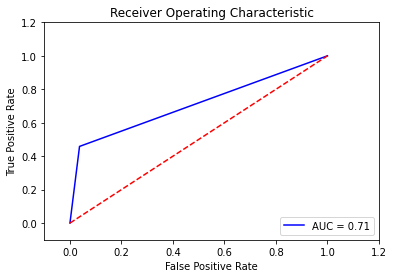

In [0]:
# Training for class 1
data = df_train[['cleaned_tweet','ngv_qlty_1']]
data.rename(columns={"ngv_qlty_1":"label"}, inplace=True)

lstm_trained_model_1 = lstm_classfier(data, w2v_model)

FV shape: (10000, 100) and Label list shape (10000,)
hi (8000, 100)
tt2
tt3
tt4
tt5
############## Splitted ################
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101   

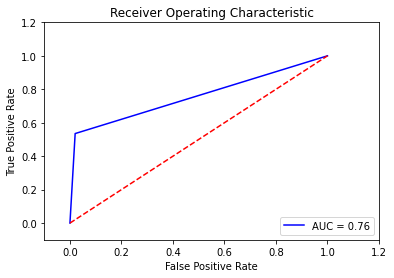

In [0]:
# Training for class 2
data = df_train[['cleaned_tweet','ngv_qlty_2']]
data.rename(columns={"ngv_qlty_2":"label"}, inplace=True)

lstm_trained_model_2 = lstm_classfier(data, w2v_model)

FV shape: (10000, 100) and Label list shape (10000,)
hi (8000, 100)
tt2
tt3
tt4
tt5
############## Splitted ################
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101   

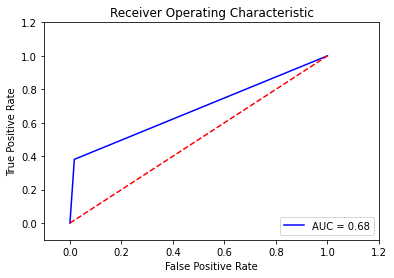

In [0]:
# Training for class 3
data = df_train[['cleaned_tweet','ngv_qlty_3']]
data.rename(columns={"ngv_qlty_3":"label"}, inplace=True)

lstm_trained_model_3 = lstm_classfier(data, w2v_model)

## Predictions on test dataset

In [0]:
df_test.drop(796, inplace=True)

In [0]:
def get_word_2_vec_fv_testing(data, model):
    FV = []

    for row in data.index:
        twt = data['cleaned_tweet'][row]
        vec = get_trans_vector(twt, model)
        if len(vec) == 100:
          FV.append(vec)
          #label_list.append(data['label'][row])
    return FV

In [0]:
FV = get_word_2_vec_fv_testing(df_test, w2v_model)
data_test = np.reshape(FV, (np.shape(FV)[0], 1, np.shape(FV)[1]))
prediction_class1 = lstm_trained_model_1.predict(data_test)
df_test['prediction_ngv_qlty_1'] = get_binary_classifcations(prediction_class1)

In [0]:
prediction_class2 = lstm_trained_model_2.predict(data_test)
df_test['prediction_ngv_qlty_2'] = get_binary_classifcations(prediction_class2)

In [0]:

prediction_class3 = lstm_trained_model_3.predict(data_test)
df_test['prediction_ngv_qlty_3'] = get_binary_classifcations(prediction_class3)

In [0]:
df_test.head()

,id,text,pre_clean_len,cleaned_tweet,post_clean_len,prediction_ngv_qlty_1,prediction_ngv_qlty_2,prediction_ngv_qlty_3
0,000b08c464718505,"""\n\n Regarding your recent edits \n\nOnce aga...",266,regarding your recent edits once again please ...,238,0.0,0.0,0.0
1,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,319,im sorry im sorry screwed around with someone ...,273,0.0,0.0,0.0
2,006b888560bcdfcd,"""know the sex of the foetus""""""",30,know the sex of the foetus,26,1.0,0.0,0.0
3,007810bde7d6ebd4,About Mitch moved to Yggdrasill \n\nI have no ...,77,about mitch moved to yggdrasill have no idea i...,70,0.0,0.0,0.0
4,00c438b052cc0f26,Appearance in historical fiction \n\nThe young...,200,appearance in historical fiction the young ric...,186,0.0,0.0,0.0


In [0]:
df_test['prediction_ngv_qlty_1'].value_counts()

0.0    1837
1.0     162
Name: prediction_ngv_qlty_1, dtype: int64

In [0]:
df_test['prediction_ngv_qlty_2'].value_counts()

0.0    1926
1.0      73
Name: prediction_ngv_qlty_2, dtype: int64

In [0]:
df_test['prediction_ngv_qlty_3'].value_counts()

0.0    1925
1.0      74
Name: prediction_ngv_qlty_3, dtype: int64